In [14]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install hyperas

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.1.1)


In [15]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt
import random

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

from hyperas.distributions import uniform



# ----------- TODO: Issues with importing imbalance-learn library
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import (RandomUnderSampler,
#                                      ClusterCentroids,
#                                      TomekLinks,
#                                      NeighbourhoodCleaningRule,
#                                      NearMiss)

In [16]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [17]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                WITH
                    max_severity AS (
                        SELECT MAX(severity) AS severity
                        FROM (
                            SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                            GROUP BY
                                incident.blockid,
                                incident.year,
                                incident.month,
                                incident.dow
                        ) AS categories
                    ),
                    block_incidents AS (
                        SELECT
                            incident.blockid,
                            incident.datetime,
                            incident.year,
                            incident.month,
                            incident.dow,
                            SUM(crimetype.severity)/AVG(block.population) AS severity
                        FROM incident
                        INNER JOIN block ON incident.blockid = block.id
                        INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                            AND block.population > 0
                            AND incident.cityid = 1
                            AND incident.year >= {start_year}
                            AND incident.year <= {end_year}
                        GROUP BY
                            incident.blockid,
                            incident.datetime,
                            incident.year,
                            incident.month,
                            incident.dow
                    )
                SELECT
                    block_incidents.blockid,
                    block_incidents.datetime,
                    block_incidents.year,
                    block_incidents.month,
                    block_incidents.dow,
                    block_incidents.severity/max_severity.severity AS severity
                FROM block_incidents, max_severity        
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [18]:
DAY_OF_WEEK  = 0
DAY_OF_MONTH = 1
HOUR_OF_DAY  = 2

def fill_data(X, y, r, start_year, end_year, blockid_dict, data_type):
    
    def day_of_month(x):
        return x.day - 1

    def hour_of_day(x):
        return x.hour
    
    if r[2] == end_year:
        if data_type == DAY_OF_WEEK:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, r[4]] = float(r[5])
            #                                            ^^^^        ^^^^
            #                                            dow         risk
        elif data_type == DAY_OF_MONTH:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, day_of_month(r[1])] = float(r[5])
            #                                            ^^^^^^^^^^^^^^^^^^        ^^^^
            #                                                  dom                 risk
        elif data_type == HOUR_OF_DAY:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, hour_of_day(r[1])] = float(r[5])
            #                                             ^^^^^^^^^^^^^^^         ^^^^
            #                                               hour of day           risk
        else:
            raise ValueError('Unsupported data type:', data_type)
    else:
        if data_type == DAY_OF_WEEK:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, r[4]] = float(r[5])
        elif data_type == DAY_OF_MONTH:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, day_of_month(r[1])] = float(r[5])
        elif data_type == HOUR_OF_DAY:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, hour_of_day(r[1])] = float(r[5])
        else:
            raise ValueError('Unsupported data type:', data_type)

In [19]:
def process_data(data, start_year, end_year, blockid_dict, data_type):

    if data_type == DAY_OF_WEEK:
        X = np.zeros((len(blockid_dict), 24, 7))
        y = np.zeros((len(blockid_dict), 12, 7))
    elif data_type == DAY_OF_MONTH:
        X = np.zeros((len(blockid_dict), 24, 31))
        y = np.zeros((len(blockid_dict), 12, 31))
    elif data_type == HOUR_OF_DAY:
        X = np.zeros((len(blockid_dict), 24, 24))
        y = np.zeros((len(blockid_dict), 12, 24))
    
    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            fill_data(X, y, r, start_year, end_year, blockid_dict, data_type)

    X = X * 1000
    y = y * 1000

    #     for i in range(24):
    #         X[:, i, -1] = (start_year*12+i) / (2000 * 12)
        
    return X, y

In [20]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year, train_blockid_dict,
               testing_start_year, testing_end_year, test_blockid_dict,
               data_type):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        train_blockid_dict,
                                        data_type)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      test_blockid_dict,
                                      data_type)

    return X_train, X_test, y_train, y_test

## Day of week analysis for each month of each block id

In [21]:
%%time

# start month = 3, end_month = 2 (months are 0-indexed)
#   X: 4/2017 -> 3/2019 actual date
#   y: 4/2019 -> 3/2020 actual date
#
X_test_start_month = 0
X_test_end_month   = 0
X_test_start_year  = 2016
X_test_end_year    = 2018

TRAIN_NUM_BLOCKIDS = TEST_NUM_BLOCKIDS = 801

TRAIN_BLOCKIDS = random.sample(list(range(1,802)), k=TRAIN_NUM_BLOCKIDS)   
train_blockid_dict = {}
for ind, blockid in enumerate(TRAIN_BLOCKIDS ):
    train_blockid_dict[blockid] = ind
        
TEST_BLOCKIDS = random.sample(list(range(1,802)), k=TEST_NUM_BLOCKIDS)    
test_blockid_dict = {}
for ind, blockid in enumerate(TEST_BLOCKIDS ):
    test_blockid_dict[blockid] = ind

CPU times: user 0 ns, sys: 1.71 ms, total: 1.71 ms
Wall time: 1.71 ms


In [22]:
def plot_output(y, y_pred, dataset_type, x_label, y_label):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

random.seed(101)

def get_predictions(X_train, y_train, X_test, y_test, 
                    x_label, y_label, model, gridsearch=False):
    
    def print_data_info(data, data_name):
        flat = data.flatten()
        print('Number of data points:', len(flat))
        print('Number of non-zero elements:', len(flat[flat > 0.0]))
        print('Percentage of non-zero elements:', len(flat[flat > 0.0])/len(flat))

        pd.Series(flat).hist(bins=[0.25, 0.5, 1.0, 1.5, 2.5, 5.0, 10, 15, 20]);
        plt.title(f'Histogram of {data_name}')
        plt.show()
    
    print_data_info(y_test, 'y_test')
    print('Correlation between y_train and y_test:\n', 
          np.corrcoef(y_train.flatten(), y_test.flatten()))
          
    X_train = X_train.reshape((TRAIN_NUM_BLOCKIDS, X_train.shape[1] * X_train.shape[2]))
    y_train = y_train.reshape((TRAIN_NUM_BLOCKIDS, y_train.shape[1] * y_train.shape[2]))
    X_test = X_test.reshape((TEST_NUM_BLOCKIDS, X_test.shape[1] * X_test.shape[2]))
    y_test = y_test.reshape((TEST_NUM_BLOCKIDS, y_test.shape[1] * y_test.shape[2]))

    print('y_test shape after reshaping:', y_test.shape)
    
    if gridsearch == True:
        # For regressors:
        param_grid = {  # param_grid values not working - have to debug --- TODO ---
            'estimator__n_estimators':  [80, 100, 120],
            'estimator__max_depth': [2, 3, 4, 5, 6],
        }

        # For classifiers:
        # param_grid = {
        #     'estimator__n_estimators':  [80, 100, 120],
        #     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
        # }

        gridsearch = GridSearchCV(model,
                                  param_grid=param_grid, 
                                  scoring='neg_mean_squared_error', 
                                  cv=3, n_jobs=-1,
                                  return_train_score=True, verbose=10)
        model = gridsearch
        best_model_params = model.cv_results_['params'][gridsearch.best_index_]
        print('Best Grid Search model:', best_model_params)

    model.fit(X_train, y_train)

    best_training_score = model.score(X_train, y_train)
    best_testing_score  = model.score(X_test, y_test)

    print(f'  Best training score:', -best_training_score)
    print(f'  Best testing score: ', -best_testing_score)

    y_pred = model.predict(X_test)
    print('mean_squared_error:', mean_squared_error(y_test, y_pred))
          
    plot_output(y_test, y_pred, 'Testing', x_label, y_label)

    def relative_percent_difference(y_true, y_pred):
        return 1 - np.absolute((y_true - y_pred) / (np.absolute(y_true) + np.absolute(y_pred)))
    
    return y_test, y_pred, relative_percent_difference(y_test, y_pred)

Number of data points: 67284
Number of non-zero elements: 58474
Percentage of non-zero elements: 0.869062481422032


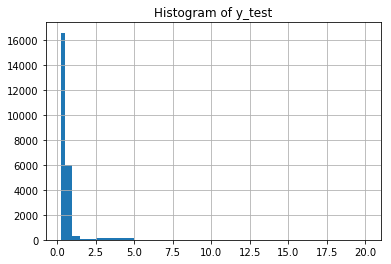

Correlation between y_train and y_test:
 [[ 1.00000000e+00 -5.49734396e-04]
 [-5.49734396e-04  1.00000000e+00]]
y_test shape after reshaping: (801, 84)
  Best training score: -0.6994744777066114
  Best testing score:  0.4437537881845414
mean_squared_error: 2.431390418883118


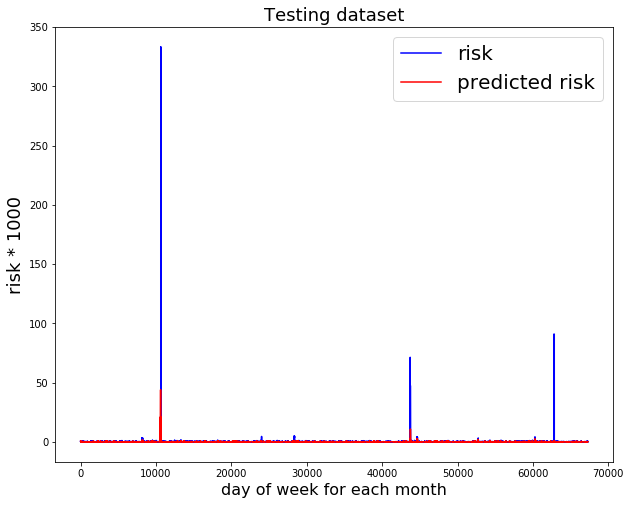

In [27]:
X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict,
                                              DAY_OF_WEEK)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)model = MultiOutputRegressor(RandomForestRegressor(max_depth=3, n_estimators=80))
y_test_dow, y_pred_dow, rpd_dow = get_predictions(X_train, y_train, X_test, y_test, 
                                                  'day of week for each month', 'risk * 1000', model)

## Day of month analysis for each month of each block id

(801, 24, 31) (801, 12, 31) (801, 24, 31) (801, 12, 31)
Number of data points: 297972
Number of non-zero elements: 143233
Percentage of non-zero elements: 0.4806928167747305


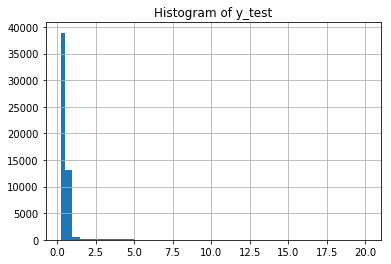

Correlation between y_train and y_test:
 [[1.00000000e+00 3.82590456e-04]
 [3.82590456e-04 1.00000000e+00]]
y_test shape after reshaping: (801, 372)
  Best training score: -0.6665515009246005
  Best testing score:  -0.15573139196640237
mean_squared_error: 0.5714824900453184


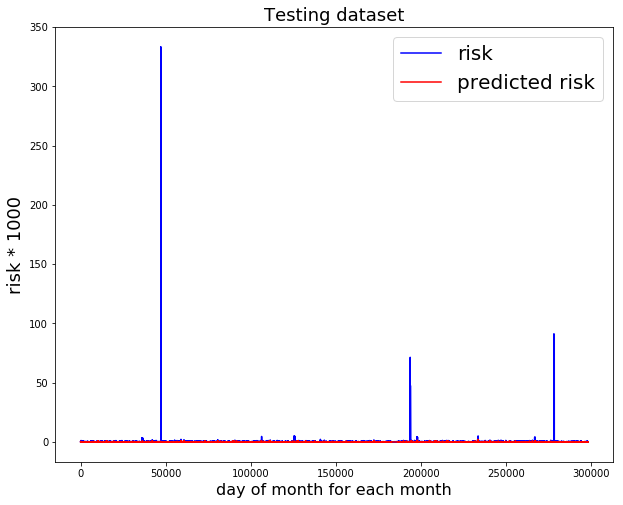

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in true_divide


In [28]:
X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict,
                                              DAY_OF_MONTH)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = MultiOutputRegressor(RandomForestRegressor(max_depth=5, n_estimators=120))
y_test_dom, y_pred_dom, rpd_dom = get_predictions(X_train, y_train, X_test, y_test, 
                                                  'day of month for each month', 'risk * 1000', model)

## Hour of day analysis for each month of each block id

(801, 24, 24) (801, 12, 24) (801, 24, 24) (801, 12, 24)
Number of data points: 230688
Number of non-zero elements: 125060
Percentage of non-zero elements: 0.5421174920238591


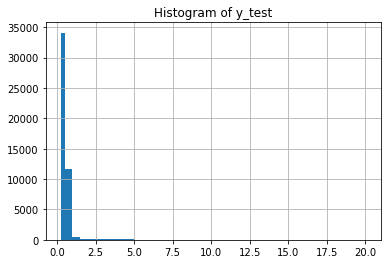

Correlation between y_train and y_test:
 [[1.00000000e+00 8.30573548e-04]
 [8.30573548e-04 1.00000000e+00]]
y_test shape after reshaping: (801, 288)
  Best training score: -0.6729653338609758
  Best testing score:  -0.1571626714691553
mean_squared_error: 0.694057927858065


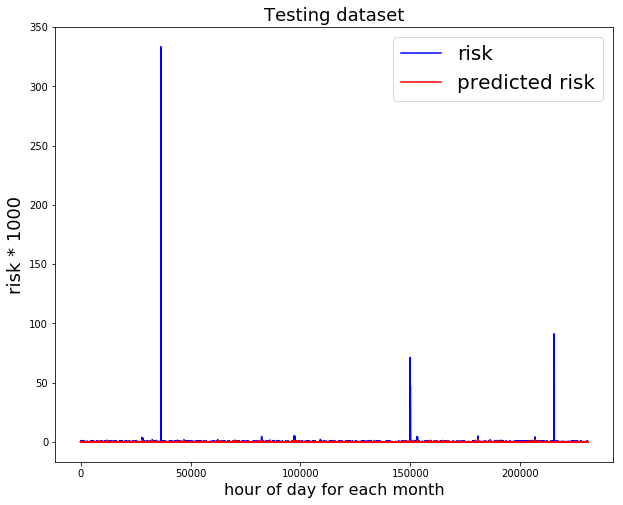

In [29]:
X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict,
                                              HOUR_OF_DAY)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = MultiOutputRegressor(RandomForestRegressor(max_depth=5, n_estimators=100))
y_test_hod, y_pred_hod, rpd_hod = get_predictions(X_train, y_train, X_test, y_test, 
                                                  'hour of day for each month', 'risk * 1000', model)

## Weigh and combine predictions into one array

In [50]:
NUM_BLOCKIDS       = 801
NUM_MONTHS_IN_YEAR = 12
NUM_DAYS_IN_WEEK   = 7
NUM_HOURS_IN_DAY   = 24

risks = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))

# This is necessary, since we want low values of relative percent difference
# to be weighed higher
rpd_dow = 1/rpd_dow
rpd_dom = 1/rpd_dom
rpd_hod = 1/rpd_hod

# Each of the relative percent difference arrays can contain NaN's.
# This is because if both y_pred and y_true were zeros, their
# addition is also zero, and we cannot divide by this zero.
# Here we replace NaN's to get around that issue.
# Since we want to have the highest weight to those values that
# have the same y_pred and y_true, we will give the largest value
# from our array to these NaNs.

def replace_nans(a):
    b = a.copy()
    for row in range(a.shape[0]):
        # max_of_row = np.max(row)
        for col in range(a.shape[1]):
            if np.isnan(a[row][col]):
                # b[row][col] = max_of_row
                b[row][col] = 1.0
    return b

rpd_dow = replace_nans(rpd_dow)
rpd_dom = replace_nans(rpd_dom)
rpd_hod = replace_nans(rpd_hod)

print('Number of nans after replacement:', np.isnan(rpd_dow).sum())

# Returns number of days in a month
def days_in_month(year, month):
    p = pd.Period(f'{year}-{month}-1')
    return p.days_in_month

# Day of week returns 0-based day value
def day_of_week(dt):
    return dt.weekday()

end_year = X_test_end_year

for blockid in range(NUM_BLOCKIDS):
    for month in range(1, NUM_MONTHS_IN_YEAR + 1):
        
        count = np.zeros(NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY)
        for day in range(1, days_in_month(end_year, month) + 1):
            for hour in range(24):
                dow  = day_of_week(datetime(end_year, month, day))

                # calculate how good y_pred - y_true is (say for hod) = abs((y_pred_hourly - y_true_hourly) / (y_pred + y_true))
                # 
                # calculate how good y_pred - y_true is (say for hod) = abs((y_pred - y_true) / (y_pred + y_true))
                #                                                      1       8         8           8        8   = 0
                #                                                      0.33   20        4           20       4   = 0.67
                #                                                      0.04   200       4           200      4   = 0.96
                #                                                      
                # calculate relative differences between hod, dow, dom
                #                                                      (pred1 * 1 + pred2 * 0.33)/(1 + 0.33)
                #                                                       0.03*pred1 + 0.24*pred2
                #                                                         (8*1      + 9*0.33)/1.33  = 8.24
                # dow risk = 10    actual = 9   weight = 1  = abs(10 - 9) / (10 + 9) = 0.05
                # dom risk = 8     actual = 8   weight = 2  = abs(8 - 8) / (8 + 8)   = 0
                #                                                 % diff same => same weights
                #                                                 %
                #   (10 * 1 + 8 * 2) / (1 + 2) = 8.6667
                weight_dow = rpd_dow[blockid, (month - 1)*dow]        # risk / #hours => hourly risk
                weight_dom = rpd_dom[blockid, (month - 1)*(day - 1)]  # risk / #hours => hourly risk
                weight_hod = rpd_hod[blockid, (month - 1)*hour]   # (blockid, month, hour)          0, 1, 2, 3 .., 23
                                                                  #    801      12    24     Day  0
                weight_sum = weight_dow + weight_dom + weight_hod #                          Day  1
                                                                  #                                 2, 1.5, 0.2, 0.01
                                                                  #                                 1, 3.5, 
                risks[blockid, month-1, dow * hour] += \
                    (y_pred_dow[blockid, (month - 1)*dow] * weight_dow +
                     y_pred_dom[blockid, (month - 1)*(day - 1)] * weight_dom +
                     y_pred_hod[blockid, (month - 1)*hour] * weight_hod) / weight_sum
                risks[blockid, month-1, dow * hour] += (y_pred_dow[blockid, (month - 1)*dow] +
                                                        y_pred_dom[blockid, (month - 1)*(day - 1)] +
                                                        y_pred_hod[blockid, (month - 1)*hour]) / weight_sum
                
                count[dow * hour] += 1
        risks[blockid, month-1, dow * hour] /= count[dow * hour]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide


Number of nans after replacement: 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in double_scalars


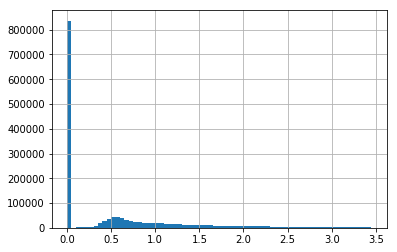

In [31]:
a = pd.Series(risks.flatten())
a.hist(bins=np.arange(0.0, 3.5, 0.05));

In [32]:
a.value_counts(normalize=True)

0.000000     5.178571e-01
0.437724     8.917425e-05
0.547154     2.477062e-05
1.430147     2.229356e-05
1.142510     2.229356e-05
0.745280     2.229356e-05
2.035960     2.229356e-05
0.880509     2.229356e-05
0.628472     2.229356e-05
1.185585     2.229356e-05
0.923076     2.229356e-05
0.758819     2.229356e-05
0.497034     2.229356e-05
0.599478     2.229356e-05
2.175295     2.229356e-05
0.579908     2.229356e-05
0.650580     2.229356e-05
0.999514     2.229356e-05
0.495048     2.229356e-05
0.528718     2.229356e-05
0.653693     2.229356e-05
0.584392     2.229356e-05
0.787093     2.229356e-05
0.466272     2.229356e-05
1.199498     2.229356e-05
0.579952     2.229356e-05
0.520584     2.229356e-05
1.304997     2.229356e-05
0.673409     2.229356e-05
0.477681     2.229356e-05
                 ...     
0.484514     6.192656e-07
36.896224    6.192656e-07
3.603835     6.192656e-07
2.291046     6.192656e-07
0.508605     6.192656e-07
0.686726     6.192656e-07
1.603182     6.192656e-07
1.257728    

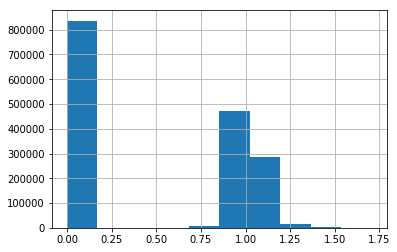

In [33]:
a = pd.Series(risks.flatten()).apply(lambda x: np.power(x, 0.1))
a.hist()  # (bins=np.arange(0.0, 3.5, 0.05));

In [34]:
per_block = risks.reshape((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR * NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))

## Store predictions in DB

In [52]:
from decouple import config

pred_blockid_dict = test_blockid_dict
def store_predictions_in_db(y_pred):
    
    DB_URI_WRITE  = config('DB_URI_WRITE')

    # Put predictions into pandas DataFrame with corresponding block id
    predictions = pd.DataFrame([[x] for x in pred_blockid_dict.keys()], columns=["id"])

    predictions.loc[:, "prediction"] = predictions["id"].apply(lambda x: y_pred[pred_blockid_dict[x],:,:].astype(np.float64).tobytes().hex())
    predictions.loc[:, "month"] = 0
    predictions.loc[:, "year"] = 2018
    predictions.to_csv("predictions.csv", index=False)

    # Query SQL
    query_commit_predictions = """
    CREATE TEMPORARY TABLE temp_predictions (
        id SERIAL PRIMARY KEY,
        prediction TEXT,
        month INTEGER,
        year INTEGER
    );

    COPY temp_predictions (id, prediction, month, year) FROM STDIN DELIMITER ',' CSV HEADER;

    UPDATE block
    SET 
        prediction = DECODE(temp_predictions.prediction, 'hex'),
        month = temp_predictions.month,
        year = temp_predictions.year 
    FROM temp_predictions
    WHERE block.id = temp_predictions.id;

    DROP TABLE temp_predictions;
    """

    # Open saved predictions and send to database using above query
    with open("predictions.csv", "r") as f:
        print("SENDING TO DB")
        RAW_CONN = create_engine(DB_URI_WRITE).raw_connection()
        cursor = RAW_CONN.cursor()
        cursor.copy_expert(query_commit_predictions, f)
        RAW_CONN.commit()
        RAW_CONN.close()

    for r in SESSION.execute("SELECT ENCODE(prediction::BYTEA, 'hex'), id FROM block WHERE prediction IS NOT NULL LIMIT 5;").fetchall():
        print(np.frombuffer(bytes.fromhex(r[0]), dtype=np.float64).reshape((12,7,24)))
        print(y_pred[pred_blockid_dict[int(r[1])], :].reshape((12,7,24)))

In [59]:
np.mean(y_test), np.mean(y_pred_hod)

(0.14566349583386135, 0.13900182949414921)

In [57]:
risks /= 1000.
risks = np.nan_to_num(risks)
with session_scope() as SESSION:
    store_predictions_in_db(risks)

SENDING TO DB
[[[5.59265925e-08 1.91529426e-09 3.83058853e-09 ... 3.44752968e-09
   3.83058853e-09 1.91529426e-09]
  [6.51200050e-09 1.53223541e-09 1.91529426e-09 ... 3.06447082e-09
   3.83058853e-10 0.00000000e+00]
  [4.59670623e-09 0.00000000e+00 1.53223541e-09 ... 1.53223541e-09
   1.53223541e-09 0.00000000e+00]
  ...
  [1.53223541e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.53223541e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.01245663e-08 6.65915944e-10 1.32141014e-09 ... 2.45823898e-09
   2.22550656e-09 7.10873173e-10]
  [5.12110387e-09 4.98973956e-10 1.09687785e-09 ... 3.01082651e-09
   1.76883515e-10 0.00000000e+00]
  [4.63077864e-09 0.00000000e+00 7.84709999e-10 ... 7.60367508e-10
   7.06209489e-10 0.00000000e+00]
  ...
  [1.38651282e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e

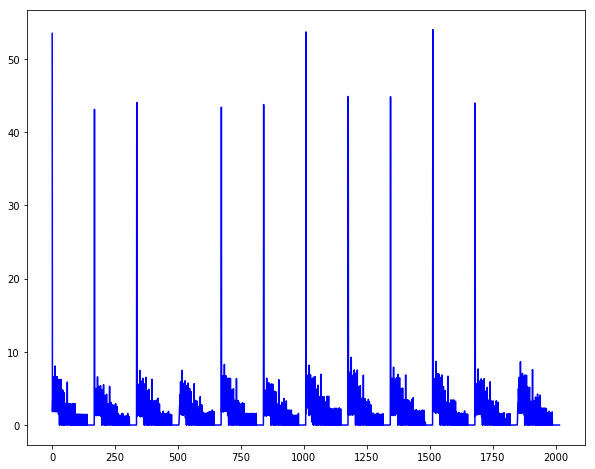

In [37]:
y = risks[82]
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.show()

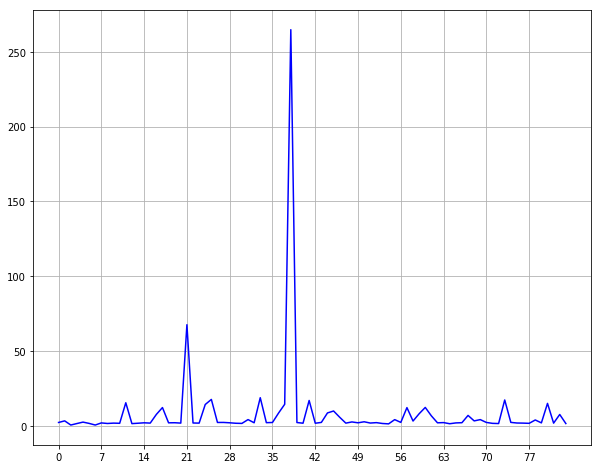

In [38]:
y = rpd_dow[82].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,84,7))
plt.grid(True)
plt.show()

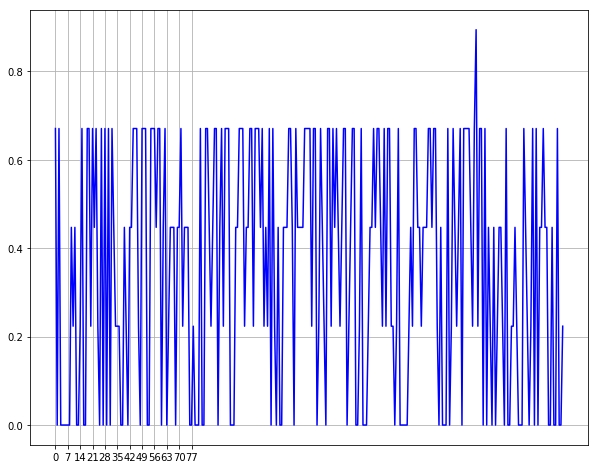

In [39]:
y = y_test[82].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,84,7))
plt.grid(True)
plt.show()

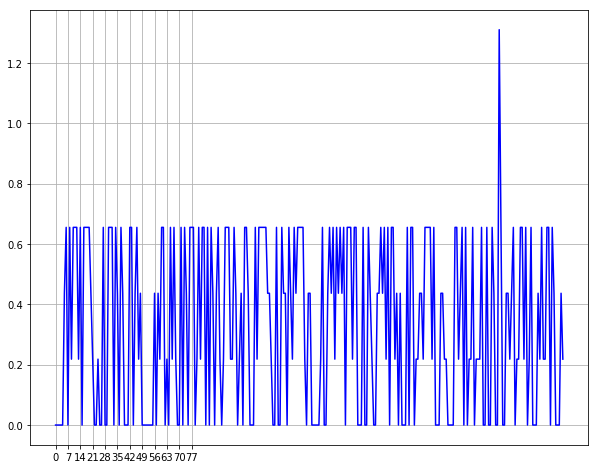

In [40]:
y = y_test[0].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,84,7))
plt.grid(True)
plt.show()

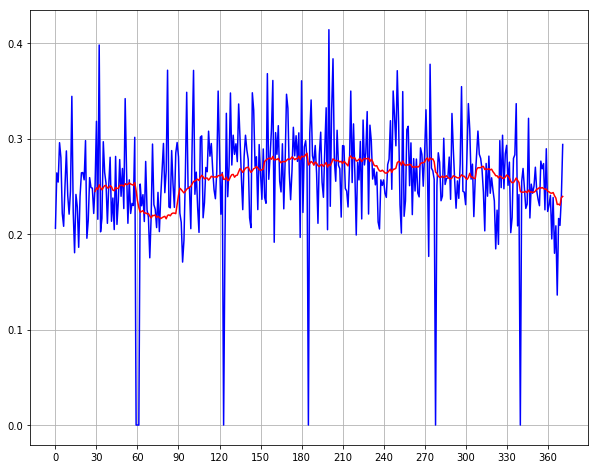

In [41]:
y = y_pred_dom[0].flatten()
df_y = pd.DataFrame(y)
df_y['ma'] = df_y.rolling(window=30).mean()

fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.plot(np.arange(df_y['ma'].shape[0]),
             df_y['ma'], color='red');
plt.xticks(np.arange(0,372, 30))
plt.grid(True)
plt.show()

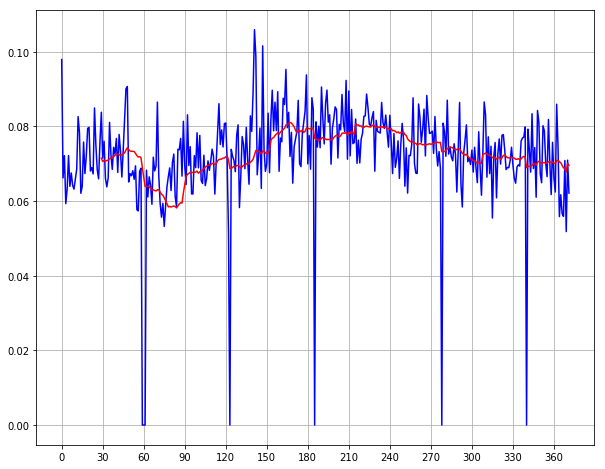

In [42]:
y = y_pred_dom[101].flatten()
df_y = pd.DataFrame(y)
df_y['ma'] = df_y.rolling(window=30).mean()

fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.plot(np.arange(df_y['ma'].shape[0]),
             df_y['ma'], color='red');
plt.xticks(np.arange(0,372, 30))
plt.grid(True)
plt.show()

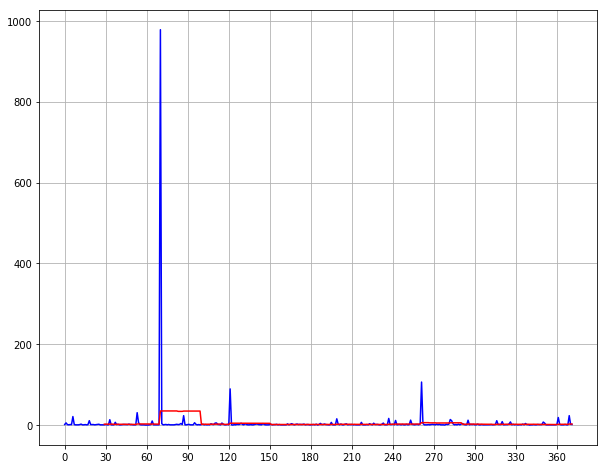

In [43]:
y = rpd_dom[0].flatten()
df_y = pd.DataFrame(y)
df_y['ma'] = df_y.rolling(window=30).mean()

fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.plot(np.arange(df_y['ma'].shape[0]),
             df_y['ma'], color='red');
plt.xticks(np.arange(0,372, 30))
plt.grid(True)
plt.show()

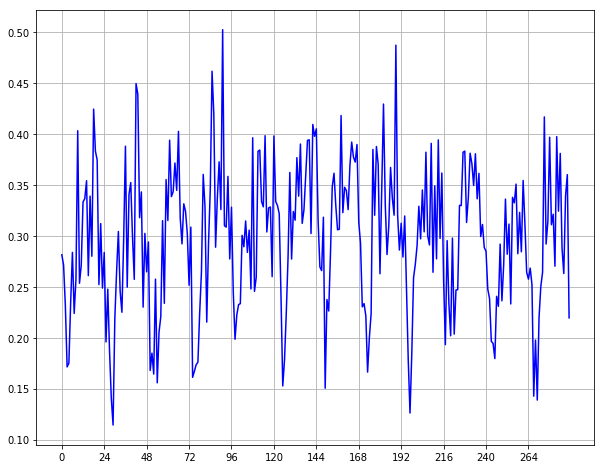

In [44]:
y = y_pred_hod[0].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,288,24))
plt.grid(True)
plt.show()

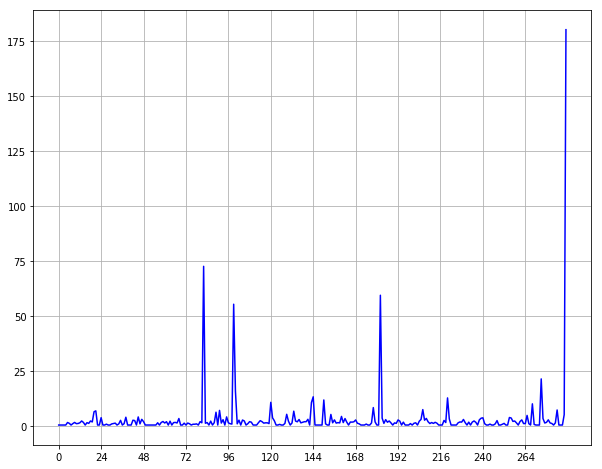

In [45]:
y = rpd_hod[0].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,288,24))
plt.grid(True)
plt.show()

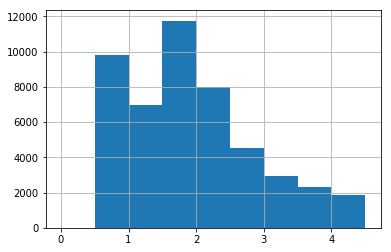

In [46]:
pd.Series(rpd_dow.flatten()).hist(bins=np.arange(0, 5, 0.5))

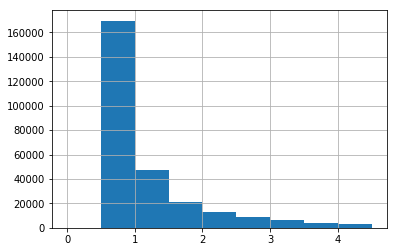

In [47]:
pd.Series(rpd_dom.flatten()).hist(bins=np.arange(0, 5, 0.5))